In [37]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

df = pd.read_csv("american_bankruptcy.csv")
df = df.drop(columns = ["company_name"])
print(df.head(10))

  status_label  year       X1        X2      X3       X4       X5      X6  \
0        alive  1999  511.267   833.107  18.373   89.031  336.018  35.163   
1        alive  2000  485.856   713.811  18.577   64.367  320.590  18.531   
2        alive  2001  436.656   526.477  22.496   27.207  286.588 -58.939   
3        alive  2002  396.412   496.747  27.172   30.745  259.954 -12.410   
4        alive  2003  432.204   523.302  26.680   47.491  247.245   3.504   
5        alive  2004  474.542   598.172  27.950   61.774  255.477  15.453   
6        alive  2005  624.454   704.081  29.222   91.877  323.592  35.163   
7        alive  2006  645.721   837.171  32.199  118.907  342.593  58.660   
8        alive  2007  783.431  1080.895  39.952  168.522  435.608  75.144   
9        alive  2008  851.312  1110.677  40.551  166.080  477.424  78.651   

        X7         X8        X9       X10      X11      X12      X13      X14  \
0  128.348   372.7519  1024.333   740.998  180.447   70.658  191.226  1

In [25]:
# 1. DATA PREPROCESSING

# Data Cleaning

missing_values = df.isnull().sum()
print("\nMissing values per column:\n", missing_values)
duplicates = df.duplicated().sum()
print("\nDuplicates in the dataset:", duplicates)


Missing values per column:
 status_label    0
year            0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
dtype: int64

Duplicates in the dataset: 0


In [26]:
# Feature Encoding (Binary Encoding)

print("\nLabels in the dataset:", df["status_label"].unique()) 
df["status_encoding"] = df["status_label"].map({"alive": 0, "failed": 1})
df["status_encoding"] = df["status_encoding"].astype(int)
df = df.drop(columns = ["status_label"])
print(df.head(10))


Labels in the dataset: ['alive' 'failed']
   year       X1        X2      X3       X4       X5      X6       X7  \
0  1999  511.267   833.107  18.373   89.031  336.018  35.163  128.348   
1  2000  485.856   713.811  18.577   64.367  320.590  18.531  115.187   
2  2001  436.656   526.477  22.496   27.207  286.588 -58.939   77.528   
3  2002  396.412   496.747  27.172   30.745  259.954 -12.410   66.322   
4  2003  432.204   523.302  26.680   47.491  247.245   3.504  104.661   
5  2004  474.542   598.172  27.950   61.774  255.477  15.453  127.121   
6  2005  624.454   704.081  29.222   91.877  323.592  35.163  136.272   
7  2006  645.721   837.171  32.199  118.907  342.593  58.660  181.691   
8  2007  783.431  1080.895  39.952  168.522  435.608  75.144  202.472   
9  2008  851.312  1110.677  40.551  166.080  477.424  78.651  227.300   

          X8        X9       X10      X11      X12      X13      X14      X15  \
0   372.7519  1024.333   740.998  180.447   70.658  191.226  163.816  20

In [ ]:
# 2. EDA

"""

YOUR CODE GOES HERE!!! Have each separate topic in its own cell.

1. Feature selection (with a heatmap and correlation analysis)
2. Data normalization (with log, inverse, and square transformations and their respective plots)
3. Outlier detection (with box-plots, and outlier detection algorithms potentially)

"""

       year        X1        X2        X3        X4        X5        X6  \
0  1.652915 -0.098432 -0.094175 -0.149182 -0.122282  0.116192 -0.070151   
1  1.652915  0.398392  0.304415  1.154211  0.896891  0.441446  0.249240   
2  0.608084 -0.163236 -0.130137 -0.172887 -0.159123 -0.036532 -0.079020   
3  0.782222  0.823411  3.293836  1.539412  0.883689  2.220233  0.352544   
4 -1.133302 -0.209286 -0.167993 -0.164052 -0.168249 -0.183554 -0.092823   
5 -0.610886 -0.098329  0.012442  0.208926  0.162574 -0.173036  0.081153   
6  1.652915 -0.143813 -0.068305  0.088031 -0.021313 -0.177570 -0.208893   
7 -0.088471 -0.098241 -0.151461 -0.144036 -0.371891 -0.191012 -0.395013   
8 -0.262609 -0.205775 -0.171854 -0.144194 -0.167007 -0.190249 -0.093003   
9  0.085668 -0.208939 -0.172719 -0.149816 -0.174012 -0.191012 -0.195659   

         X7        X8        X9       X10       X11       X12       X13  \
0 -0.111058 -0.129712 -0.105293 -0.160393 -0.221582 -0.099594 -0.110748   
1  0.705604  0.534685  0

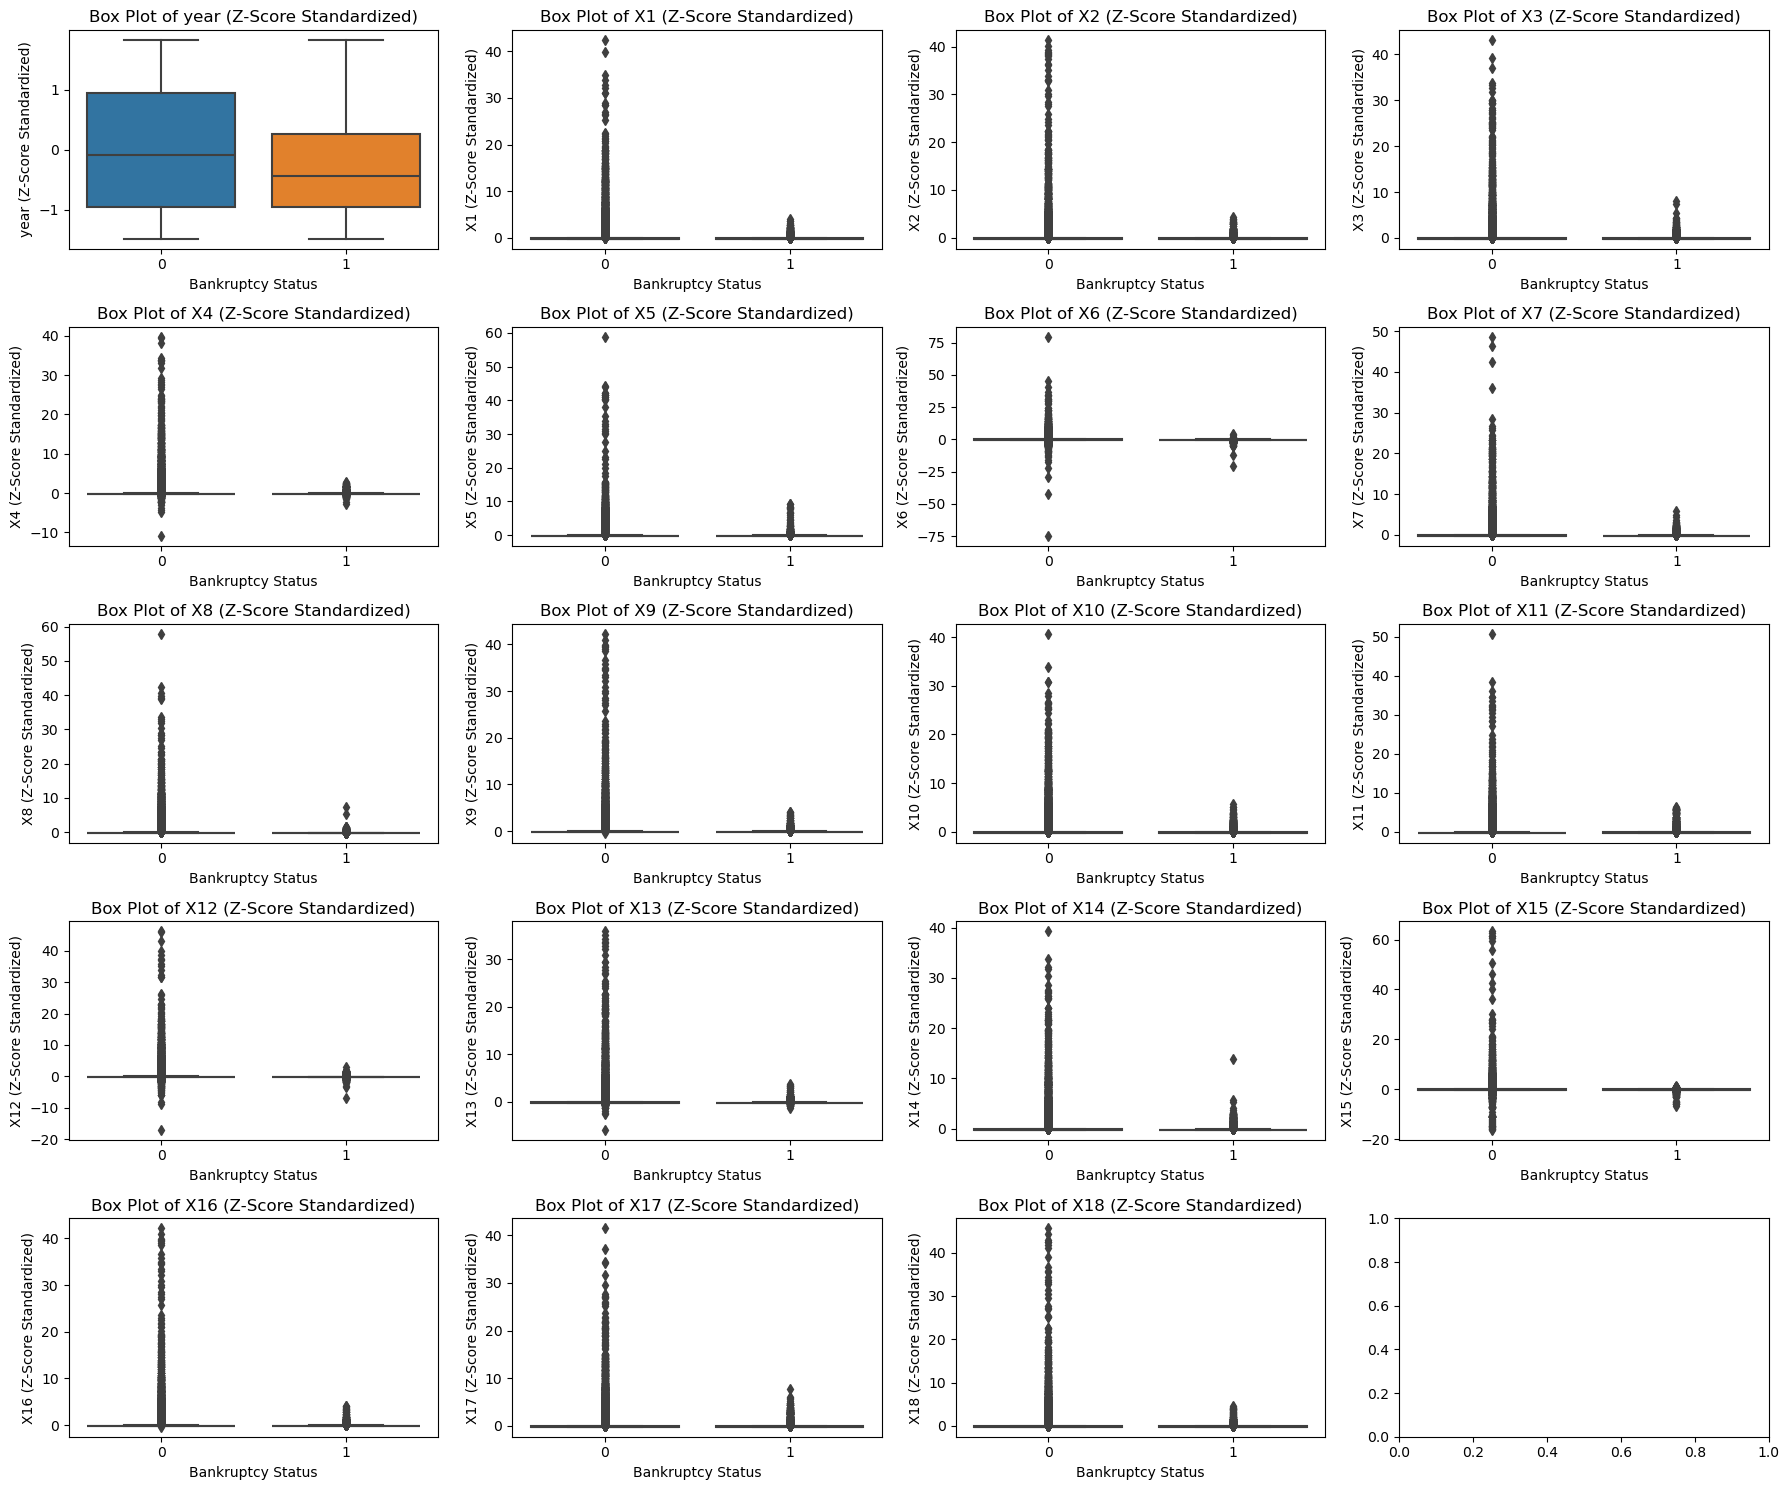

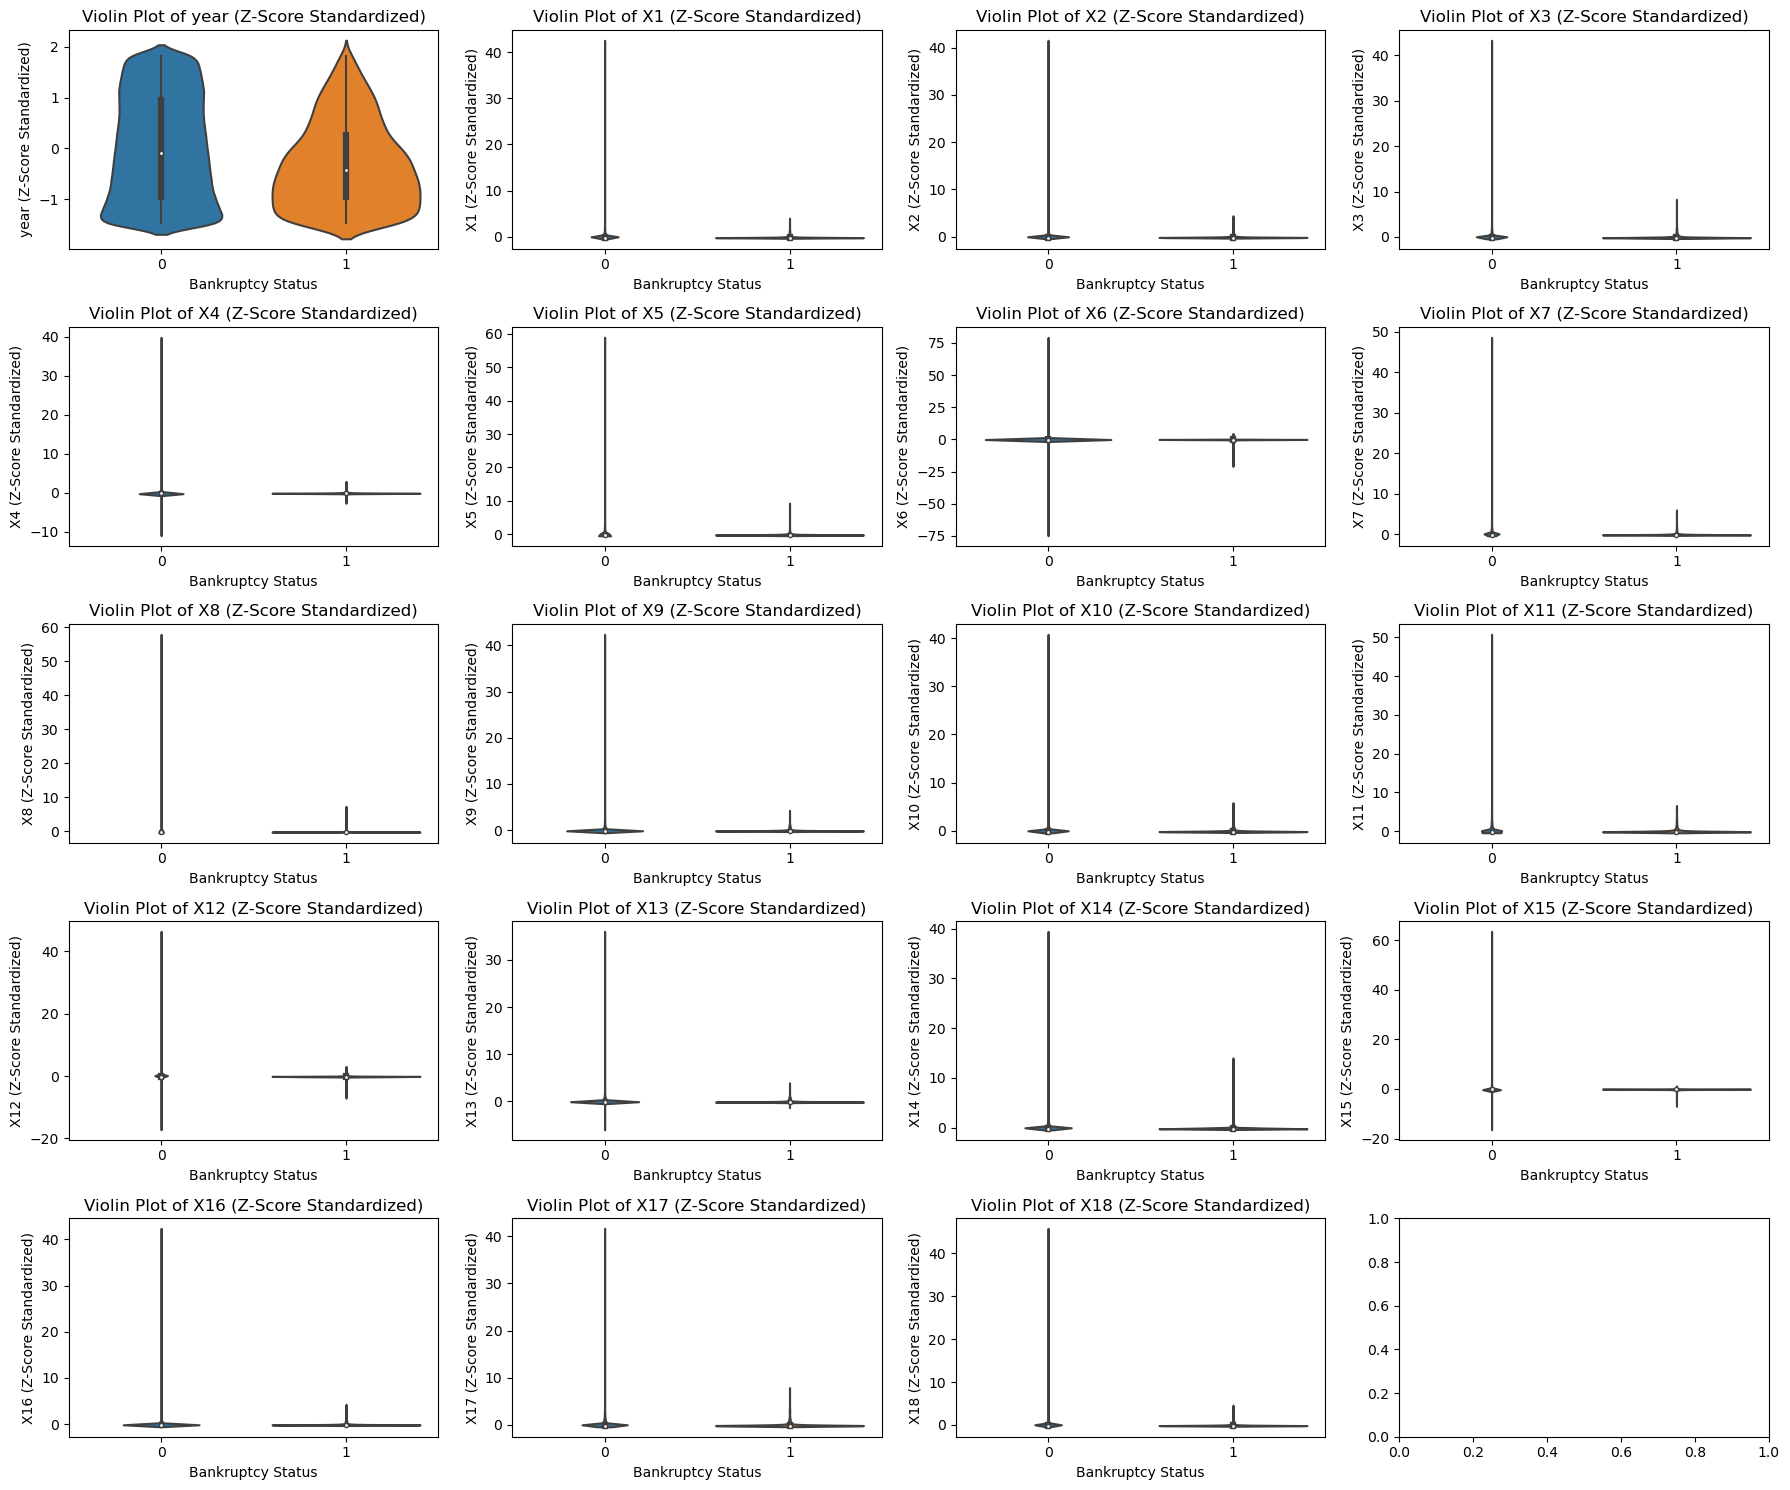

In [36]:
# Data Scaling/Standardization

scaler = StandardScaler() # Scaler for Z-Score standardization

X = df.iloc[:, :-1] # Select all of the rows in the dataset, but disregard the last column (i.e. the target column, "status_encoding")
y = df["status_encoding"] # Select the "status_encoding" column (i.e. the target column)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = 0.20, shuffle = True) # Split the dataset

X_train_scaled = scaler.fit_transform(X_train) # Calculate the mean and standard deviation of X_train and perform the Z-Score standardization
X_test_scaled = scaler.transform(X_test) # Apply it on X_test with the previously calculated mean and standard deviation to avoid data leakage

train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns = X.columns), pd.DataFrame(y_train.reset_index(drop = True), columns = ["status_encoding"])], axis = 1)
test_scaled = pd.concat([pd.DataFrame(X_test_scaled, columns = X.columns), pd.DataFrame(y_test.reset_index(drop = True), columns = ["status_encoding"])], axis = 1)
df_scaled = pd.concat([train_scaled, test_scaled], axis = 0) # Contains our dataset, but scaled using Z-Score standardization
print(df_scaled.head(10))
print("\n\n\n\n")

diagram_columns = 4 # Can be adjusted to make all of the graphs fit perfectly depending on the number of selected attribute columns
attribute_columns = df_scaled.shape[1] - 1 # Remember to disregard the target column, "status_encoding", as it is not one of our attribute columns
diagram_rows = math.ceil(attribute_columns / diagram_columns) # Find the maximum number of rows in our diagram to fit every attribute's plot

row_index = 0
column_index = 0
fig, axes = plt.subplots(diagram_rows, diagram_columns, figsize = (18, diagram_rows * 3))
for column in df_scaled.columns[:-1]:
    sns.boxplot(x = "status_encoding", y = column, data = df_scaled, ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(f"Box Plot of {column} (Z-Score Standardized)")
    axes[row_index, column_index].set_xlabel("Bankruptcy Status")
    axes[row_index, column_index].set_ylabel(f"{column} (Z-Score Standardized)")
    column_index += 1
    if column_index == diagram_columns:
        row_index += 1
        column_index = 0
plt.tight_layout()
plt.show()

print("\n\n\n\n")

row_index = 0
column_index = 0
fig, axes = plt.subplots(diagram_rows, diagram_columns, figsize = (18, diagram_rows * 3))
for column df_scaled.columns[:-1]:
    sns.violinplot(x = "status_encoding", y = column, data = df_scaled, ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(f"Violin Plot of {column} (Z-Score Standardized)")
    axes[row_index, column_index].set_xlabel("Bankruptcy Status")
    axes[row_index, column_index].set_ylabel(f"{column} (Z-Score Standardized)")
    column_index += 1
    if column_index == diagram_columns:
        row_index += 1
        column_index = 0
plt.tight_layout()
plt.show()